In [1]:
#meta 4/5/2021 How to read a markup file
#NLP, LSHTC (large scale hierarchical text classification)
#src data http://lshtc.iit.demokritos.gr/ LSHTC3
#src code based on https://github.com/Arf4t/Lshtc3_fasttext/blob/master/LSHTC3.ipynb

#input: LSHTC3 wikipediaMediumOriginalLSHTCv3-train.txt (variations) markup file
#output: df.pkl with documents and labels

#history
#4/5/2021 READ FILE
#      OOP class read markup file
#4/14/2021 READ MARKUP FILE AND RETURN TIDY DF
#      Explore labels
#      Prep data - df, one label per df row

#4/15/2021 READ MARKUP FILE AND RETURN TIDY DF WITH LESS LABELS
#      N_LOW_COUNT = 500
#      Smaller df_tidy, with less than 200 labels

#4/15/2021 TIDY DF WITH LESS LABELS, REINDEXED
#      pandas df.explode lists to rows, ignore index - requires pandas 1.1.0+
#      update pandas in env nlp_lshtc

#4/21/2021 DF FINAL - DOCNO, TEXT and HANDLE MULTI-LABELS
#      Encode target - multi-labels per document

#4/23/2021 REDO DF W/ MULTI-LABELS
#      Org and clean creation of Imploded df subset w/ multi-labels
#      Full df
#      456886 documents x 3 fields docno, labels, text
#      (1 rec = 1 doc -> many labels)
#      confirmed: 36504 unique labels

#      Full Exploded df -> explode each doc into records with 1 label per doc
#      842792 records x 3 fields docno, label, text
#      (1 rec -> many docs, 1 rec = 1 label)
#      confirmed: 36504 unique labels

#      Subset Exploded df -> remove docs with low count labels
#      151800 records x 3 fields docno, label, text
#      (1 rec -> many docs, 1 rec = 1 label)
#      confirmed: 139 unique labels

#      Subset Imploded df -> implode labels from each record into docs with multi labels per doc
#      127043 imploded documents x 3 fields docno, text, labels
#      (1 rec = 1 doc -> many labels)
#      confirmed: 139 unique labels
#          
#      $kaggle diff

In [2]:
#$kaggle
#! conda install -c anaconda beautifulsoup4 -y 

In [3]:
import time as time #to track performance time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from bs4 import BeautifulSoup
from scipy import stats

from joblib import load, dump

In [4]:
#global vars

#$kaggle
#TRAIN_FILE = '../input/mylshtc3train/wikipediaMediumOriginalLSHTCv3-train.txt'
#TEST_FILE = '../input/mylshtc3train/wikipediaMediumOriginalLSHTCv3-test.txt'

TRAIN_FILE = 'data/wikipediaMediumOriginalLSHTCv3-train.txt'
TEST_FILE = 'data/wikipediaMediumOriginalLSHTCv3-test.txt'

DOC_LABEL = 1
N_LOW_COUNT = 1
N_BINS = 50

In [5]:
#define a class to read a markup file and extract its elements
class myTextReader:
    """
    docstring for myTextReader
    read a markup file and return index, text, and labels
    input: specifically formattted file, i.e. LSHTCv3 markup text file
    output: lists of docs index, text, and labels
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.docno=[]
        self.labels=[]                      #parsing the required data about labels and documents
        self.data=[]
        
        soup=BeautifulSoup(open(self.file_path,'r',encoding='utf8'),'html.parser')
        
        for x in list(soup.find_all('docno')):
            self.docno.append(x.get_text())

        for x in list(soup.find_all('labels')):
            self.labels.append([ int(lab) for lab in x.get_text().split()])
            self.data.append(x.next_sibling.strip('\n'))

# LSHTC3

## 0.  Load Train Data
Read a Markup File - input and multiple labels

Full train ds:  
456886 documents x 3 fields `docno`, `labels`, `text`  
842792 transformed labels -> 36504 unique labels  
(1 rec = 1 doc ->  many labels)    


In [6]:
#track time
t0 = time.time()

#read file
train_data = myTextReader(TRAIN_FILE) #class __main__.myTextReader

#display a couple of entities
train_data.docno[1:3], train_data.labels[1:3], train_data.data[1:3]

print("Processing time (in minutes): ", (time.time() - t0)/60)

Processing time (in minutes):  1.1494065046310424


In [7]:
#explore text - number of documents
train_data.docno[-1], train_data.labels[-1], train_data.data[-1]

('456886',
 [49901],
 'The Christie Harris Illustrated Children\\u2019s Literature Prize is awarded annually as the BC Book Prize for the author and illustrator of the best picture books, picture story books, and illustrated non-fiction books. The prize is shared by the author and the illustrator, who must be a resident of British Columbia or the Yukon, Canada. It was first awarded in 2002.')

### 0.1 EDA

#### Explore Labels
Flatten labels - convert a nD list into a 1D list by un-nesting each list item stored in the list of lists

> Note: run into a nb limitation.  To change this limit, set the config variable `--NotebookApp.iopub_data_rate_limit`.  
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [8]:
#flatten labels
labels_list = [item for sublist in train_data.labels for item in sublist]
print('Transformed list preview: ', labels_list[:25])
print('Transformed list count: ', len(labels_list))

Transformed list preview:  [33692, 13402, 393382, 130762, 352578, 395447, 27512, 157031, 390846, 395447, 276114, 14661, 71999, 292915, 188756, 131368, 106615, 228092, 420589, 228506, 307963, 207086, 119558, 159586, 188582]
Transformed list count:  842792


In [9]:
#unique labels with counts
#src https://numpy.org/doc/stable/reference/generated/numpy.unique.html
labels_unique, labels_indices, labels_counts = np.unique(np.array(labels_list), return_inverse=True, return_counts = True)
print(labels_unique[:10], labels_counts[:10]) 
#print(labels_unique[-10:], labels_counts[-10:])
print(labels_indices[:10], labels_unique[labels_indices[:10]])

labels_unique.shape, labels_unique.max(), labels_counts.max()

[ 1 14 19 24 33 40 47 53 61 79] [26 13  1 12  4  4 39  3  8  9]
[ 2791  1095 32252 10689 28858 32423  2270 12879 32029 32423] [ 33692  13402 393382 130762 352578 395447  27512 157031 390846 395447]


((36504,), 445729, 11400)

Confirm count of labels

In [10]:
stats.describe(labels_counts)

DescribeResult(nobs=36504, minmax=(1, 11400), mean=23.087661626123165, variance=10044.76940204357, skewness=50.073420200053654, kurtosis=4793.583431118063)

In [11]:
labels_counts.min(), labels_counts.mean(), np.median(labels_counts), labels_counts.max()

(1, 23.087661626123165, 8.0, 11400)

In [12]:
#set N_LOW_COUNT
#N_LOW_COUNT = int(np.median(labels_counts))

#### Explore Labels Visually

(array([36113,   240,    52,    41,    21,    13,     7,     5,     2,
           2,     0,     3,     1,     2,     0,     0,     0,     0,
           1,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     1], dtype=int64), array([1.000000e+00, 2.289800e+02, 4.569600e+02, 6.849400e+02,
       9.129200e+02, 1.140900e+03, 1.368880e+03, 1.596860e+03,
       1.824840e+03, 2.052820e+03, 2.280800e+03, 2.508780e+03,
       2.736760e+03, 2.964740e+03, 3.192720e+03, 3.420700e+03,
       3.648680e+03, 3.876660e+03, 4.104640e+03, 4.332620e+03,
       4.560600e+03, 4.788580e+03, 5.016560e+03, 5.244540e+03,
       5.472520e+03, 5.700500e+03, 5.928480e+03, 6.156460e+03,
       6.384440e+03, 6.612420e+03, 6.840400e+03, 7.068380e+03,
       7.296360e+03, 7.524340e+03, 7.752320e+03, 7.980300e+03,
       8.208280e+03, 8.43

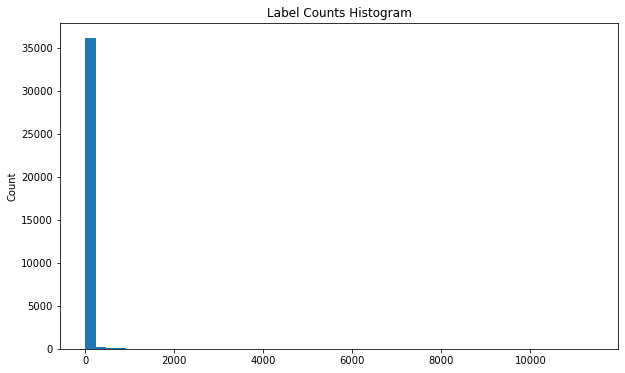

In [13]:
#visualize labels shape - so many ones
print(np.histogram(labels_counts, bins = N_BINS))
plt.hist(labels_counts, bins = N_BINS)
plt.title("Label Counts Histogram")
plt.ylabel("Count")
plt.show()

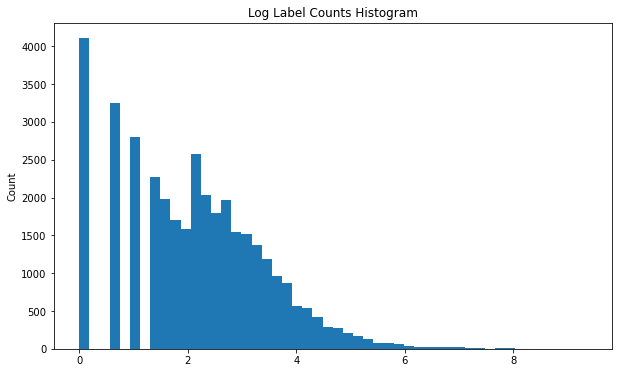

In [14]:
#visualize labels shape
plt.hist(np.log(labels_counts), bins = N_BINS)
plt.title("Log Label Counts Histogram")
plt.ylabel("Count")
plt.show()

#### Explore a Specific Label
How many labels 1? Label 1 indices

In [15]:
print(labels_list.count(DOC_LABEL))

#first index with label 1?
labels_list.index(DOC_LABEL)

#all indices with label 1
np.where(labels_indices == 0)[0]
#labels_list[104236]


26


array([ 87198, 104236, 116699, 126074, 173758, 173763, 185136, 224772,
       243313, 268117, 337477, 347188, 461050, 501496, 521941, 530044,
       560621, 563316, 579411, 608222, 626176, 626540, 626918, 737877,
       796029, 836061], dtype=int64)

#### Explore Labels with Low Count
How many labels with count 1? Count 1 indices, count 1 labels

In [16]:
print(labels_counts.tolist().count(1))
#all indices with label count=1, all labels with count=1
np.where(labels_counts == 1)[0], labels_unique[np.where(labels_counts == 1)[0]]

4107


(array([    2,    21,    22, ..., 36496, 36501, 36503], dtype=int64),
 array([    19,    270,    280, ..., 445637, 445683, 445729]))

Consider rolling up one level

#### Explore Most frequent Labels (with Highest Count)

In [17]:
#most frequent labels counts
print((sorted(labels_counts))[-10:])

#which label most frequent?
idx_label_most_frequent, = np.where(labels_counts == 11400) #tuple
label_most_frequent = labels_unique[idx_label_most_frequent]
idx_label_most_frequent, label_most_frequent

[2242, 2253, 2527, 2538, 2723, 2826, 3009, 3067, 4289, 11400]


(array([13739], dtype=int64), array([167593]))


## 0.  Load Test Data
Read a Markup File - with input only

In [18]:
#track time
t0 = time.time()

#read file
test_data = myTextReader(TEST_FILE) #class __main__.myTextReader

#display a couple of entities
test_data.docno[1:3], test_data.labels[1:3], test_data.data[1:3]

print("Processing time (in minutes): ", (time.time() - t0)/60)

Processing time (in minutes):  0.3382618069648743


In [19]:
#explore text - number of documents
test_data.docno[-1], test_data.labels[-1], test_data.data[-1]

('81262',
 [0],
 'Rancho Ca\\u00F1ada de la Segunda was a 4,367-acre (17.67 km) Mexican land grant in present day Monterey County, California given in 1839 by Governor Jos\\u00E9 Castro to Lazaro Soto. The grant extended along the north bank of the Carmel River, from the Pacific coast and present day Carmel-by-the-Sea up into the Carmel Valley.')

In [20]:
#flatten labels - confirm no labels
labels_test_list = [item for sublist in test_data.labels for item in sublist]
print('Transformed list preview: ', labels_test_list[:25])
print('Transformed list count: ', len(labels_test_list))

Transformed list preview:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Transformed list count:  81262


In [21]:
#unique labels with counts
labels_test_unique, labels_test_counts = np.unique(np.array(labels_test_list), return_counts = True)
print(labels_test_unique, labels_test_counts) 


[0] [81262]


## 1. Prep Data

### 1.0 Full Dataset
- Full df    
456886 documents x 3 fields `docno`, `labels`, `text`  
(1 rec = 1 doc ->  many labels)    
confirmed: 36504 unique labels

In [22]:
df = pd.DataFrame([train_data.docno, train_data.labels, train_data.data]).T
df.columns = ['docno', 'labels', 'text']
#df.set_index('docno', inplace=True)

print(df.shape)
print(df.dtypes)
df.head()

(456886, 3)
docno     object
labels    object
text      object
dtype: object


,docno,labels,text
0,1,"[33692, 13402, 393382]",Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
1,2,[130762],Alain Connes (born 1 April 1947) is a French m...
2,3,"[352578, 395447, 27512, 157031]",Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
3,4,"[390846, 395447, 276114]","Allan Dwan (April 3, 1885 – December 28, 1981)..."
4,5,"[14661, 71999, 292915, 188756, 131368]","Andre Kirk Agassi (born April 29, 1970) is an ..."


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456886 entries, 0 to 456885
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   docno   456886 non-null  object
 1   labels  456886 non-null  object
 2   text    456886 non-null  object
dtypes: object(3)
memory usage: 10.5+ MB


In [24]:
#save df
#$kaggle
#dump(df, 'lshtc3_wikipedia_med_df_train_full.pkl')
dump(df, 'output/lshtc3_wikipedia_med_df_train_full.pkl')

['output/lshtc3_wikipedia_med_df_train_full.pkl']

### 1.1 Explode Labels - one label per df row
Exploded lists to rows of the subset columns; index will be duplicated for these rows  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html

#### 1.1.0 Exploded df - one label per df row 

- Full Exploded df -> explode each doc into records with 1 label per doc  
842792 records x 3 fields `docno`, `label`, `text`  
(1 rec -> many docs, 1 rec = 1 label)    
confirmed: 36504 unique labels

In [25]:
#explode labels lists to rows, ignore index - requires pandas 1.1.0+
df_full_unilabel = df.explode('labels', ignore_index=True)
df_full_unilabel.columns = ['docno', 'label', 'text']

print(df_full_unilabel.shape)
df_full_unilabel.head(10)

(842792, 3)


,docno,label,text
0,1,33692,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
1,1,13402,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
2,1,393382,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
3,2,130762,Alain Connes (born 1 April 1947) is a French m...
4,3,352578,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
5,3,395447,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
6,3,27512,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
7,3,157031,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
8,4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
9,4,395447,"Allan Dwan (April 3, 1885 – December 28, 1981)..."


In [26]:
#confirm unique labels count
df_full_unilabel['label'].describe()

count     842792
unique     36504
top       167593
freq       11400
Name: label, dtype: int64

### 1.2 Remove Low Count Labels

#### 1.2.0 Exploded df subset - one label per df row 

- Subset Exploded df -> remove docs with low count labels  
151800 records x 3 fields `docno`, `label`, `text`  
(1 rec -> many docs, 1 rec = 1 label)    
confirmed: 139 unique labels

In [27]:
N_LOW_COUNT = 500

In [28]:
#repeat from above
print(labels_counts.tolist().count(N_LOW_COUNT))
#all indices with label count=1, all labels with count=1
np.where(labels_counts == N_LOW_COUNT)[0], labels_unique[np.where(labels_counts ==N_LOW_COUNT)[0]]

1


(array([27512], dtype=int64), array([335454]))

In [29]:
#ie. in full train ds - know that labels 19, 445729 only happened once
labels_list.count(19), labels_list.count(445729)

(1, 1)

In [30]:
labels_low_count = labels_unique[np.where(labels_counts < N_LOW_COUNT)[0]]
labels_low_count

array([     1,     14,     19, ..., 445683, 445705, 445729])

In [31]:
#confirm (manually) counts before and after match 
df_sub_unilabel = df_full_unilabel[~df_full_unilabel['label'].isin(labels_low_count)]
print(df_sub_unilabel.shape)
df_sub_unilabel.head(10)

(151800, 3)


,docno,label,text
3,2,130762,Alain Connes (born 1 April 1947) is a French m...
4,3,352578,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
5,3,395447,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
6,3,27512,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
8,4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
9,4,395447,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
11,5,14661,"Andre Kirk Agassi (born April 29, 1970) is an ..."
16,6,106615,Aldous Leonard Huxley (26 July 1894 \u2013 22 ...
30,11,27512,Albert Einstein (14 March 1879\u201318 April 1...
36,13,303577,"Alfred Habdank Skarbek Korzybski (July 3, 1879..."


In [32]:
#confirm that removed label 393382 had only 1 count, label 335454 500 count
labels_list.count(393382), labels_list.count(335454)

(1, 500)

In [33]:
df_sub_unilabel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151800 entries, 3 to 842771
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   docno   151800 non-null  object
 1   label   151800 non-null  object
 2   text    151800 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


#### 1.2.1 Post EDA of Exploded Subset
w/ no low count labels 
##### Explore Labels in Subset
Confirm count of labels in exploded subset

In [34]:
df_sub_unilabel['label'].value_counts()

167593    11400
347803     4289
352578     3067
284433     3009
283823     2826
          ...  
335156      508
10307       508
239004      503
131503      502
335454      500
Name: label, Length: 139, dtype: int64

In [35]:
df_sub_unilabel['label'].describe()

count     151800
unique       139
top       167593
freq       11400
Name: label, dtype: int64

##### Explore Docs in Subset
Confirm count of docs in exploded subset

In [36]:
print(df_sub_unilabel['docno'].unique())
print(len(df_sub_unilabel['docno'].unique()))
df_sub_unilabel['docno'].describe()

['2' '3' '4' ... '456869' '456870' '456871']
127043


count     151800
unique    127043
top        31173
freq           9
Name: docno, dtype: object

In [37]:
#save df
#$kaggle
#dump(df_full_unilabel, 'lshtc3_wikipedia_med_df_train_high_count.pkl')
#dump(df_sub_unilabel, 'lshtc3_wikipedia_med_df_train_high_count.pkl')
dump(df_full_unilabel, 'output/lshtc3_wikipedia_med_df_train_full_unilabel.pkl')
dump(df_sub_unilabel, 'output/lshtc3_wikipedia_med_df_train_sub_unilabel.pkl')

['output/lshtc3_wikipedia_med_df_train_sub_unilabel.pkl']

### 1.3 Implode Labels - multi labels for subset
Concatenate strings from several rows using Pandas groupby
https://www.geeksforgeeks.org/concatenate-strings-from-several-rows-using-pandas-groupby/

In [38]:
df_sub_multilabel = df_sub_unilabel.copy()
print(df_sub_multilabel.shape)
df_sub_multilabel['label'] = df_sub_multilabel['label'].astype('str')
print(df_sub_multilabel.dtypes)
df_sub_multilabel.head(10)

(151800, 3)
docno    object
label    object
text     object
dtype: object


,docno,label,text
3,2,130762,Alain Connes (born 1 April 1947) is a French m...
4,3,352578,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
5,3,395447,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
6,3,27512,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
8,4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
9,4,395447,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
11,5,14661,"Andre Kirk Agassi (born April 29, 1970) is an ..."
16,6,106615,Aldous Leonard Huxley (26 July 1894 \u2013 22 ...
30,11,27512,Albert Einstein (14 March 1879\u201318 April 1...
36,13,303577,"Alfred Habdank Skarbek Korzybski (July 3, 1879..."


In [39]:
df_sub_multilabel_temp = df_sub_multilabel.groupby('docno')['label'].transform(lambda x: ' '.join(x)) #.reset_index()
#not the right place to drop duplicates
#df_sub_multilabel_temp = df_sub_multilabel_temp.drop_duplicates() 
df_sub_multilabel_temp.name = 'labels'

print(df_sub_multilabel_temp.shape)
print(df_sub_multilabel_temp.index.unique()[:10])
df_sub_multilabel_temp.head(10)

(151800,)
Int64Index([3, 4, 5, 6, 8, 9, 11, 16, 30, 36], dtype='int64')


3                  130762
4     352578 395447 27512
5     352578 395447 27512
6     352578 395447 27512
8           390846 395447
9           390846 395447
11                  14661
16                 106615
30                  27512
36                 303577
Name: labels, dtype: object

#### 1.3.0 Imploded df subset - multi label per document (=df row)

- Subset Imploded df -> implode labels from each record into docs with multi labels per doc  
127043 imploded documents x 3 fields `docno`, `text`, `labels`  
(1 rec = 1 doc ->  many labels)   
confirmed: 139 unique labels 

In [40]:
#Combine subset df with `text` field and subset series with imploded `labels` :  
df_sub_multilabel = pd.merge(df_sub_multilabel, df_sub_multilabel_temp, how='inner', left_index=True, right_index=True)
df_sub_multilabel.drop('label', axis=1, inplace=True)
#drop docs with same `docno`
df_sub_multilabel.drop_duplicates(inplace=True) 

print(df_sub_multilabel.shape)
df_sub_multilabel.head()

(127043, 3)


,docno,text,labels
3,2,Alain Connes (born 1 April 1947) is a French m...,130762
4,3,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...,352578 395447 27512
8,4,"Allan Dwan (April 3, 1885 – December 28, 1981)...",390846 395447
11,5,"Andre Kirk Agassi (born April 29, 1970) is an ...",14661
16,6,Aldous Leonard Huxley (26 July 1894 \u2013 22 ...,106615


In [41]:
#save df
#$kaggle
#dump(df_sub_multilabel, 'lshtc3_wikipedia_med_df_train_sub_multilabel.pkl')
dump(df_sub_multilabel, 'output/lshtc3_wikipedia_med_df_train_sub_multilabel.pkl')

['output/lshtc3_wikipedia_med_df_train_sub_multilabel.pkl']

#### Summary of arriving to the final `train` subset with limited # of labels

1. Full df    
456886 documents x 3 fields `docno`, `labels`, `text`  
(1 rec = 1 doc ->  many labels)    
confirmed: 36504 unique labels

2. Full Exploded df -> explode each doc into records with 1 label per doc  
842792 records x 3 fields `docno`, `label`, `text`  
(1 rec -> many docs, 1 rec = 1 label)    
confirmed: 36504 unique labels

3. Subset Exploded df -> remove docs with low count labels  
151800 records x 3 fields `docno`, `label`, `text`  
(1 rec -> many docs, 1 rec = 1 label)    
confirmed: 139 unique labels

4. Subset Imploded df -> implode labels from each record into docs with multi labels per doc  
127043 imploded documents x 3 fields `docno`, `text`, `labels`  
(1 rec = 1 doc ->  many labels)   
confirmed: 139 unique labels  


In [42]:
mystop

NameError: name 'mystop' is not defined

## Xtra

### Xtra Encode target - multi-labels per document

Given a dataset with two features, we let the encoder find the unique values per feature and transform the data to a binary one-hot encoding.  
https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


Imploded subset ds shape:  
127043 docs x 139 unique labels

In [ ]:
#$xtra no need for OHE label encoding
ohe = pd.get_dummies(df_sub_unilabel['label'], prefix='label')
print(ohe.shape)
ohe.head()

In [ ]:
#add ohe labels to df_sub_unilabel
df_sub_ohe_multilabel = pd.concat([df_sub_unilabel, ohe], axis=1)
print(df_sub_ohe_multilabel.shape)
df_sub_ohe_multilabel.head()

Get to matrix shape:  
n docs x m unique labels

In [ ]:
df_y = df_sub_ohe_multilabel.groupby('docno').sum()
print(df_y.shape)
df_y.head()

Combine X&y:  
127403 docs x 139 unique labels + original `labels` and `text` fields

In [ ]:
#revisit full df
df.set_index('docno', inplace=True)
print(df.shape)
df.head()

In [ ]:
df_sub_ohe_multilabel = pd.merge(df, df_y, how='inner', left_index=True, right_index=True)
print(df_sub_ohe_multilabel.shape)
df_sub_ohe_multilabel.head()

In [ ]:
#verify right labels for a sample doc
print(df.loc['3'])
df_sub_ohe_multilabel.loc['3'][['text', 'label_106615','label_352578', 'label_395447','label_27512']]

In [ ]:
#save df
#$kaggle
#dump(df_sub_ohe_multilabel, 'lshtc3_wikipedia_med_df_train_ohe_multilabel.pkl') 
dump(df_sub_ohe_multilabel, 'output/lshtc3_wikipedia_med_df_train_ohe_multilabel.pkl') 

In [ ]:
mystop

In [ ]:
#xtra manually, replicate Class - read an html file
tiny_docno=[]
tiny_labels=[]                      #parsing the required data about labels and documents
tiny_data=[]
        
soup=BeautifulSoup(open('input/wikipediaMediumOriginalLSHTCv3-train_tiny.txt','r',encoding='utf8'),'html.parser')

for x in list(soup.find_all('docno')):
    tiny_docno.append([ int(lab) for lab in x.get_text().split()])

for x in list(soup.find_all('labels')):
    tiny_labels.append([ int(lab) for lab in x.get_text().split()])
    tiny_data.append(x.next_sibling.strip('\n'))
    
#results after reading file
tiny_docno[1:3], tiny_labels[1:3], tiny_data[1:3]

In [ ]:
#xtra flatten list of lists example
#src https://stackabuse.com/python-how-to-flatten-list-of-lists/
#may run into nb limiation -  To change this limit, set the config variable `--NotebookApp.iopub_data_rate_limit`.  
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

regular_list = [[1, 2, 3, 4], [5, 6, 7], [8, 9]]
flat_list = [item for sublist in regular_list for item in sublist]
print('Original list', regular_list)
print('Transformed list', flat_list)

In [ ]:
#xtra find indices in array of values (not used here)
#Create a numpy array from a list of numbers
print([[11, 19, 18], [14, 15, 11], [19, 21, 46], [29, 21, 19]].__class__)
arr = np.array([[11, 19, 18], [14, 15, 11], [19, 21, 46], [29, 21, 19]])
print(arr)

result = np.where(arr == 19)
print(result)

listOfIndices= list(zip(result[0], result[1]))

for indice in listOfIndices:
    print(indice)

In [ ]:
#index of where most frequent label $acrevisit
idx2_label_most_frequent = []
for idx_most in train_data.labels:
    if label_most_frequent in idx_most:
        idx2_label_most_frequent.append(idx_most)

#confirm counts       
print(len(idx2_label_most_frequent))
#preview
idx2_label_most_frequent[:5]